In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sounddevice as sd
from scipy.signal import chirp,windows
from math import  floor,ceil
from random import  random
def cos_signal(freq,t,a=1,phase=0):
     return np.cos(2*np.pi*freq*t+phase)
def chirp_signal(freq,t,a=1):
     return chirp(t,f0=freq-5,f1=freq,t1=1)
signal_basis=[cos_signal,chirp_signal]

def next_power_of_2(x):
  if x <= 0:
    return 1  # 2^0 = 1, the smallest power of 2

  k = math.ceil(math.log2(x + 1)) #log base 2 of x+1 and rounded up
  return 2**k
def add_noise(signal, snr_db=20):
  
     signal_power = np.mean(signal**2)
     noise_power = signal_power / (10**(snr_db/10))
    
   
        # Additive White Gaussian Noise
     noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
     noisy_signal = signal + noise
     return noisy_signal

def str2sig(data,freq_min,freq_max,clock_time,sampling_rate,level,ampitude=1,phase=0,is_phase_random=False,full_plot=False):
     

     tmp=[]
     N=len(data)
     sampling = sampling_rate
     clock_time=clock_time/math.pow(2,level)
     t=np.linspace(0,clock_time,ceil(sampling*clock_time))
     window=1
    # window = windows.tukey(ceil(sampling*clock_time),1.5/2**level)
    
     
     
     #print("debug",freq_min,freq_max,clock_time,sampling_rate*clock_time,ceil(sampling*clock_time),sampling_rate)
     current_phase = phase  
     
     for i in data:
          if i == '1':
               segment = signal_basis[0](freq_max, t, phase=current_phase)*window
               current_phase = (current_phase + 2*np.pi*freq_max*clock_time) % (2*np.pi)
          elif i == '0':
               segment = signal_basis[0](freq_min, t, phase=current_phase)*window
               current_phase = (current_phase + 2*np.pi*freq_min*clock_time) % (2*np.pi)
          elif i == '2':
               segment = t*0
          tmp.append(segment)
     
     x = np.concatenate(tmp)
     #print("len",len(x))
     
  
     #print(x)
     return x
     
def generator_signal(data,freq_padding,time_per_changed,times,init_freq=0,sampling_rate=-1,\
                     dynamic_padding=False,_step_factor=1,full_plot=True,snr_db=0):
     
     y_in=[]
     N=len(data)
     maxnum_per_freq=int(floor(times/time_per_changed))
     times=maxnum_per_freq*time_per_changed # fitting time with time_per_changes
     level = int(math.ceil(math.log2(N/maxnum_per_freq+1)))
     padding_char = '2'*(maxnum_per_freq*int(math.pow(2,level))-N)
     data=data + (padding_char)
     #print(level)
     segment_freq=[]
     _freq_padding=freq_padding
     _acumulate_freq = 0
     _count=0
     
     for i in range(1,level*2,2):
          if(dynamic_padding):
               _acumulate_freq+=_freq_padding
               segment_freq.append( [_acumulate_freq,_acumulate_freq+_freq_padding])
               print([_acumulate_freq,_acumulate_freq+_freq_padding])
               #print("gg",_acumulate_freq,_freq_padding+_acumulate_freq)
               _acumulate_freq+=_freq_padding
               _count+=1
               if(_count%_step_factor==_step_factor-1):
                    _freq_padding*=2
          else:segment_freq.append([i*freq_padding,(i+1)*freq_padding])
     segment_freq =np.array(segment_freq)+init_freq
     #print(np.max(segment_freq))
     sampling_freq = max(max(2*next_power_of_2(np.max(segment_freq)),2**(level)),sampling_rate)
     # splice data
     datas = [data[maxnum_per_freq*(int(math.pow(2,i))-1):min(maxnum_per_freq*(int(math.pow(2,i+1)-1)),len(data))] for i in range(level)]
     y_out=np.zeros(ceil(times*sampling_freq))
     #print(sampling_freq)
     if(full_plot):fig, axes = plt.subplots(level+1, 1, figsize=(10, 10)) 
     for i in range(level):
          tmp=str2sig(datas[i],segment_freq[i][0],segment_freq[i][1],\
                      time_per_changed,sampling_freq,level=i,phase=(i*np.pi/level),is_phase_random=False,full_plot=True)
          #print(f"Level {i}, y_out size: {len(y_out)}, tmp size: {len(tmp)}")
          N=len(datas[i])
          clcok_time = time_per_changed/math.pow(2,i)
          if(full_plot):
               axes[i].plot(np.linspace(0,N*clcok_time,N*ceil(sampling_freq*clcok_time)),tmp, label=f"Level:{i}")
               axes[i].legend(loc='upper right')
               
          y_in.append(tmp)
          y_out+=tmp
     #y_out =add_noise(y_out,snr_db)
     if(full_plot):
          axes[level].plot(np.linspace(0,times,ceil(times*sampling_freq)),y_out)
     return [segment_freq,y_out,y_in,datas,sampling_freq,freq_padding,time_per_changed,times]

In [7]:
test_str="Hello,How Are You Doing?"
res = str(''.join(format(ord(i), '08b') for i in test_str))
print(res)


segment_freq,comb_signal,input_seperate_signal,datas,sampling_freq,freq_padding,\
     time_per_change,all_time=generator_signal(res,4,1,1,init_freq=0
                                               ,dynamic_padding=True,_step_factor=1,full_plot=False)
print("max_ampitude",np.max(np.abs(comb_signal)))
print(sampling_freq)
print(len(res))

for i in segment_freq:
     print(i)

010010000110010101101100011011000110111100101100010010000110111101110111001000000100000101110010011001010010000001011001011011110111010100100000010001000110111101101001011011100110011100111111
[4, 8]
[16, 24]
[40, 56]
[88, 120]
[184, 248]
[376, 504]
[760, 1016]
[1528, 2040]
max_ampitude 6.878301831045603
4096
192
[4 8]
[16 24]
[40 56]
[ 88 120]
[184 248]
[376 504]
[ 760 1016]
[1528 2040]


In [8]:
from scipy.io.wavfile import write


In [11]:
sd.play(comb_signal,sampling_freq)

In [10]:
write("output.wav",sampling_freq,comb_signal)

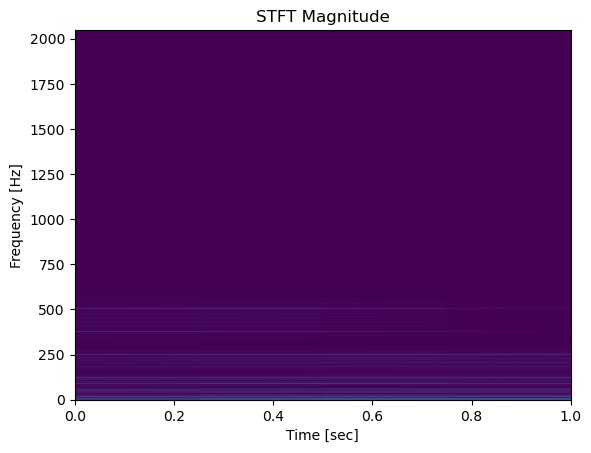

In [61]:
from scipy.signal  import stft,windows

nperseg=sampling_freq
f, t, Zxx = stft(comb_signal, sampling_freq, nperseg=nperseg,window=windows.hann(nperseg))

plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


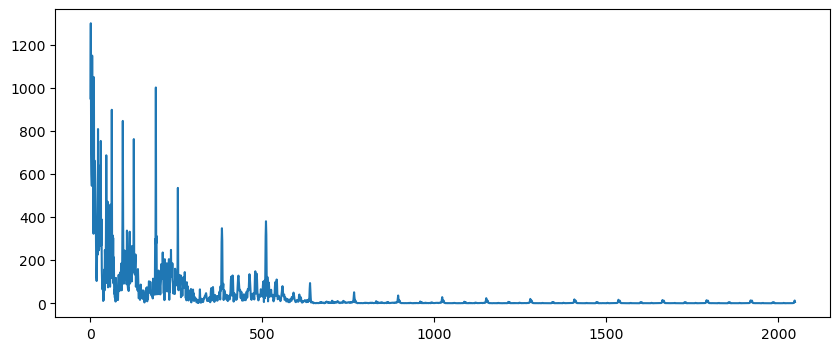

In [10]:
coef = np.fft.fft(comb_signal*windows.tukey(len(comb_signal)))
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0,(len(coef))//2,int(len(coef))//2),np.abs(coef[:len(coef)//2]))

Perform Signal Processing

In [31]:
import numpy as np
from scipy.signal import butter, filtfilt,find_peaks,firwin
import matplotlib.pyplot as plt


def duplicate_signal(signal,n=1):
     return [signal for _ in range(n)]


def goertzel_magnitude(samples, target_freq, fs):
    samples=samples*windows.tukey(len(samples))
    
    N = len(samples)

    k = int(0.5 + (N * target_freq) / fs)
    omega = 2 * np.pi * k / N
    coeff = 2 * np.cos(omega)
    d1 = d2 = 0
    for x in samples:
        d0 = x + coeff * d1 - d2
        d2, d1 = d1, d0
    return np.sqrt(d1**2 + d2**2 - d1*d2*coeff)

def fft_range(time_per_change,fs,fsignal,segment_freq,full_plot=False):
     
     #print(np.array(fsignal).shape)
     sort_layer_coeff=[]
     for level in range(0,len(segment_freq)):
          sort_coeff = []
          nperseg = math.ceil(time_per_change*fs/(math.pow(2,level)))
          #print('nperseg',nperseg)
          number_segment = math.floor(len(fsignal)/nperseg) 
          
          mid_freq = int((segment_freq[level][0]+segment_freq[level][1])/2)
          fadding_count=0
          for i in range(number_segment):
               

               index_min = int(max(0,i*(nperseg)))
               index_max = int(min((i+1)*(nperseg),len(fsignal)-1))
               #print(i,index_min,index_max)
               zero_padding_signal = fsignal[index_min:index_max]
               #plt.plot(zero_padding_signal)
               magnitude_x = goertzel_magnitude(zero_padding_signal,segment_freq[level][0],sampling_freq)
               magnitude_y = goertzel_magnitude(zero_padding_signal,segment_freq[level][1],sampling_freq)
               #print(np.array(zero_padding_signal).shape)
               #print(nperseg,magnitude_x,magnitude_y,nperseg/max(magnitude_x,magnitude_y),max(magnitude_x,magnitude_y)/min(magnitude_x,magnitude_y))
               ratio = max(magnitude_x,magnitude_y)/min(magnitude_x,magnitude_y)
               sort_coeff.append(ratio)
               if(ratio <1.5):
                   decode_binary.append('2')
               elif(magnitude_x>magnitude_y):
                   decode_binary.append('0')
               else: decode_binary.append('1')
               #sort_coeff.append(fft_index)
          sort_layer_coeff.append(np.mean(sort_coeff))
     
     return sort_layer_coeff




decode_binary=[]

used_filtered=False

fft_coeff = fft_range(time_per_change,sampling_freq,comb_signal,segment_freq)
string_out = ''.join(decode_binary)

def compare_string(target,test):
    N=len(target)
    count=0
    for i in range(N):
        count+=1 if target[i]==test[i] else 0
    return count*100/N
count=0
for i,st in enumerate(datas):
    #print(count,count+len(st))
    percent = compare_string(st,string_out[count:count+len(st)])
    print(f"layer:{i} percent{percent}")
    count=count+len(st)

print(string_out)
print(res)
print("percent: ",compare_string(res,string_out))



layer:0 percent100.0
layer:1 percent100.0
layer:2 percent100.0
layer:3 percent100.0
layer:4 percent100.0
layer:5 percent100.0
layer:6 percent100.0
layer:7 percent66.40625
010010000110010101101100011011000110111100101100010010000110111101110111001000000100000101110010011001010010000001011001011011110111010100100000010001000110111101101001011011100110011100111211222000022220020001222001200201012210022000000200012000022000000
010010000110010101101100011011000110111100101100010010000110111101110111001000000100000101110010011001010010000001011001011011110111010100100000010001000110111101101001011011100110011100111111
percent:  99.47916666666667


In [27]:
t=res

used_filtered=False
def compare_string(target,test):
    #print("T:",test)
    #print("O:",target)
    N=0
    count=0
    for i in range(len(target)):
        if(target[i]=='2'):
            break
        count+=1 if target[i]==test[i] else 0
        N+=1
    #print(N)
    return round(count*100/N,2)
def compare_remain(target,test):
    
    count=0
    N=0

    for i in range(len(target)):
        if(target[i]!='2'):continue
        count+=1 if target[i]==test[i] else 0
        N+=1
    if(N==0):return -1
    return round(count*100/N,2)
decode_binary=[]


count=0
for i,st in enumerate(datas):
    #print(count,count+len(st))
    percent = compare_string(st,string_out[count:count+len(st)])
    remain_percent = compare_remain(st,string_out[count:count+len(st)])
    print(f"layer:{i} percent:{percent},freq_range:{segment_freq[i]} remain_percent:{remain_percent},ratio:{round(fft_coeff[i],2)}")
    count=count+len(st)

#print(string_out)
print("percent: ",compare_string(t,string_out))


layer:0 percent:0.0,freq_range:[1 2] remain_percent:-1,ratio:1.82
layer:1 percent:0.0,freq_range:[4 6] remain_percent:-1,ratio:2.0
layer:2 percent:50.0,freq_range:[10 14] remain_percent:-1,ratio:6.07
layer:3 percent:50.0,freq_range:[22 30] remain_percent:-1,ratio:2.34
layer:4 percent:6.25,freq_range:[46 62] remain_percent:-1,ratio:1.71
layer:5 percent:3.12,freq_range:[ 94 126] remain_percent:-1,ratio:1.52
layer:6 percent:0.0,freq_range:[190 254] remain_percent:-1,ratio:1.58
layer:7 percent:0.0,freq_range:[382 510] remain_percent:0.0,ratio:25.95
percent:  4.17


length:192,padding_freq:2,duration_update:1,duartion:1,initfrewq:0,dynamic_freqFalse,step_feq:0.125
layer:0 percent100.0,freq_range:[2 4] remina_percent:0.0,ratio:2.24
layer:1 percent50.0,freq_range:[6 8] remina_percent:0.0,ratio:1.92
layer:2 percent0.0,freq_range:[10 12] remina_percent:0.0,ratio:1.02
layer:3 percent0.0,freq_range:[14 16] remina_percent:0.0,ratio:1.0
layer:4 percent0.0,freq_range:[18 20] remina_percent:0.0,ratio:1.0
layer:5 percent0.0,freq_range:[22 24] remina_percent:0.0,ratio:1.0
layer:6 percent0.0,freq_range:[26 28] remina_percent:0.0,ratio:1.0
layer:7 percent53.84615384615385,freq_range:[30 32] remina_percent:0.0,ratio:nan
percent:  19.270833333333332
length:192,padding_freq:2,duration_update:1,duartion:1,initfrewq:0,dynamic_freqFalse,step_feq:1


/tmp/ipykernel_198741/789270760.py:48: RuntimeWarning: invalid value encountered in scalar divide
  ratio = max(magnitude_x,magnitude_y)/min(magnitude_x,magnitude_y)


layer:0 percent100.0,freq_range:[2 4] remina_percent:0.0,ratio:3.11
layer:1 percent100.0,freq_range:[6 8] remina_percent:0.0,ratio:2.67
layer:2 percent25.0,freq_range:[10 12] remina_percent:0.0,ratio:1.13
layer:3 percent0.0,freq_range:[14 16] remina_percent:0.0,ratio:1.0
layer:4 percent0.0,freq_range:[18 20] remina_percent:0.0,ratio:1.0
layer:5 percent0.0,freq_range:[22 24] remina_percent:0.0,ratio:1.0
layer:6 percent0.0,freq_range:[26 28] remina_percent:0.0,ratio:1.0
layer:7 percent53.84615384615385,freq_range:[30 32] remina_percent:0.0,ratio:nan
percent:  20.3125
length:192,padding_freq:2,duration_update:1,duartion:1,initfrewq:4,dynamic_freqFalse,step_feq:0.125
layer:0 percent100.0,freq_range:[6 8] remina_percent:0.0,ratio:5.19
layer:1 percent100.0,freq_range:[10 12] remina_percent:0.0,ratio:7.72
layer:2 percent25.0,freq_range:[14 16] remina_percent:0.0,ratio:1.1
layer:3 percent25.0,freq_range:[18 20] remina_percent:0.0,ratio:2.07
layer:4 percent12.5,freq_range:[22 24] remina_percent

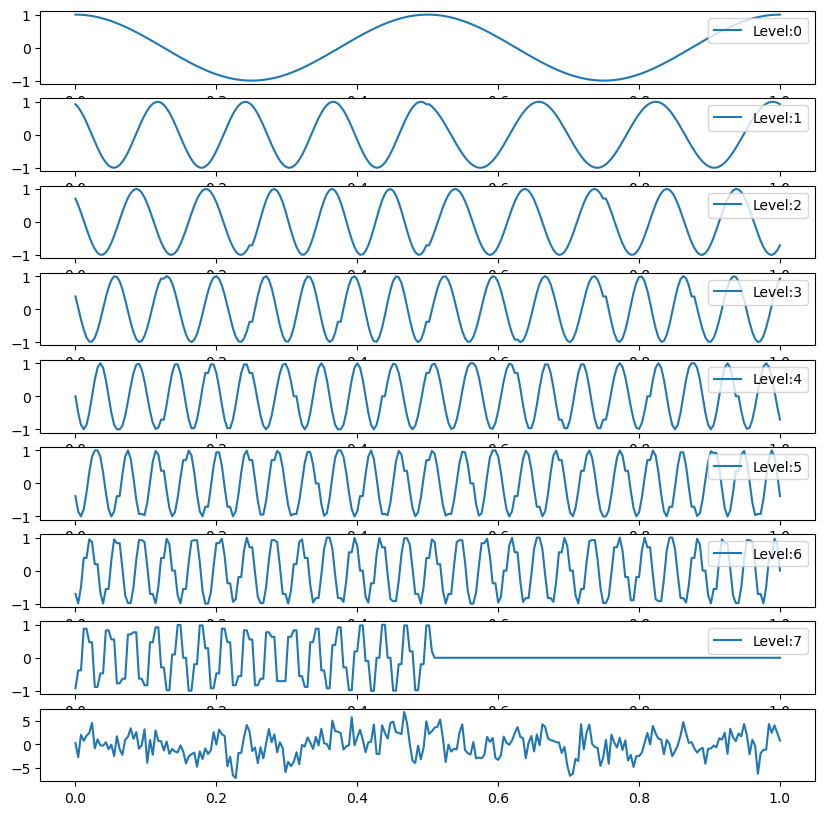

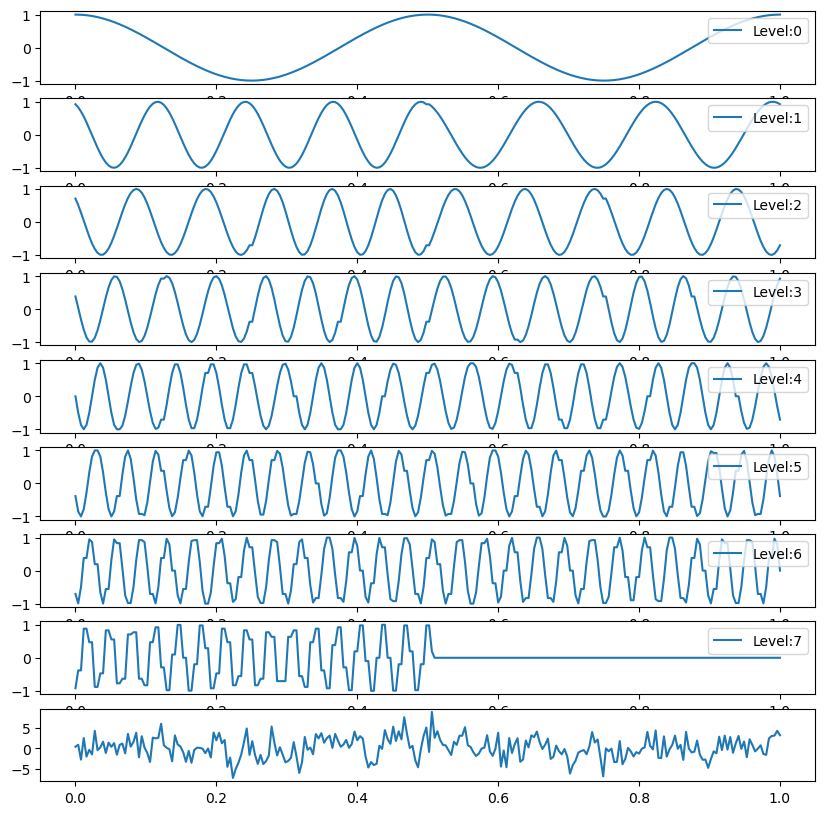

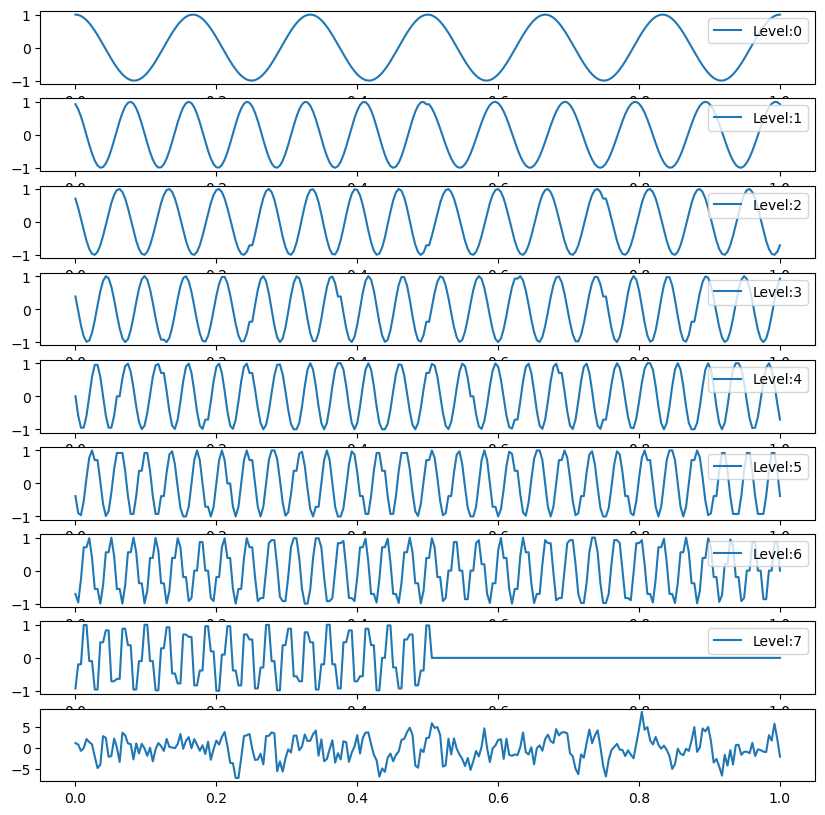

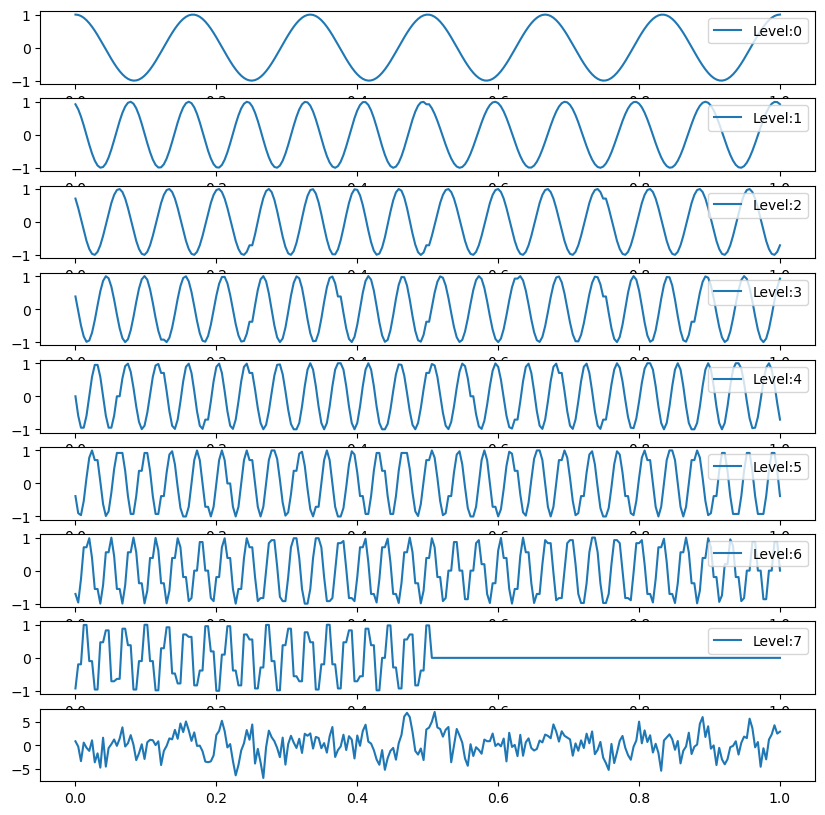

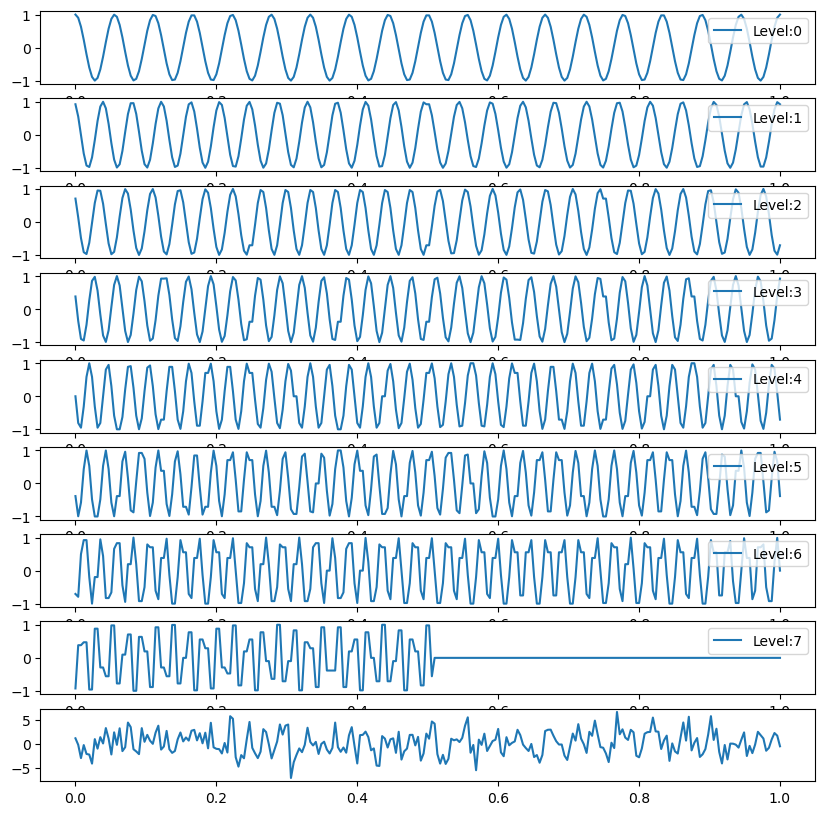

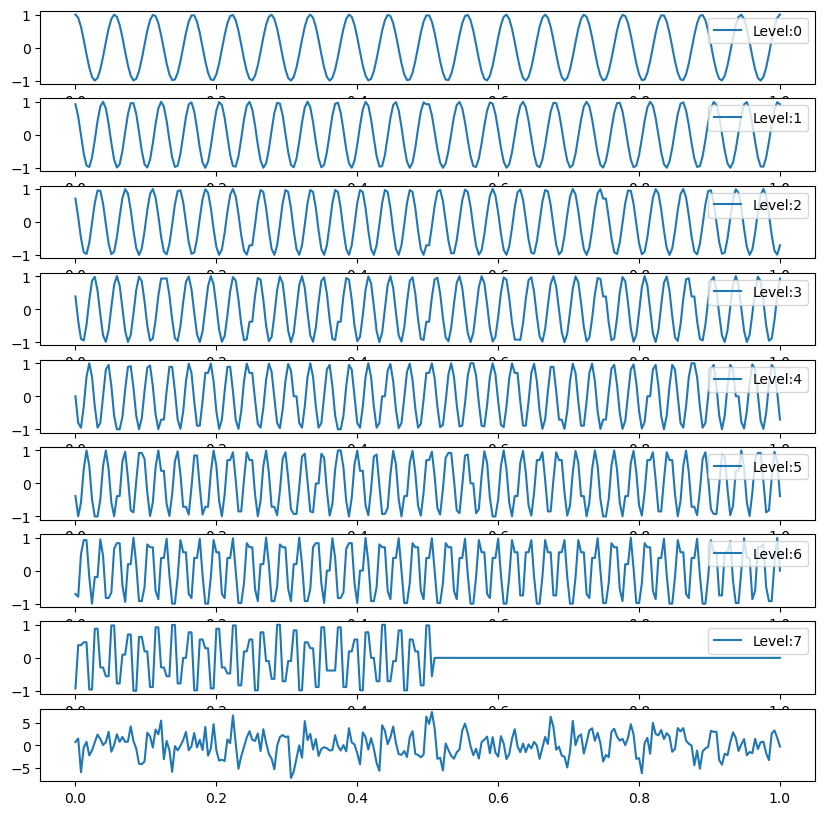

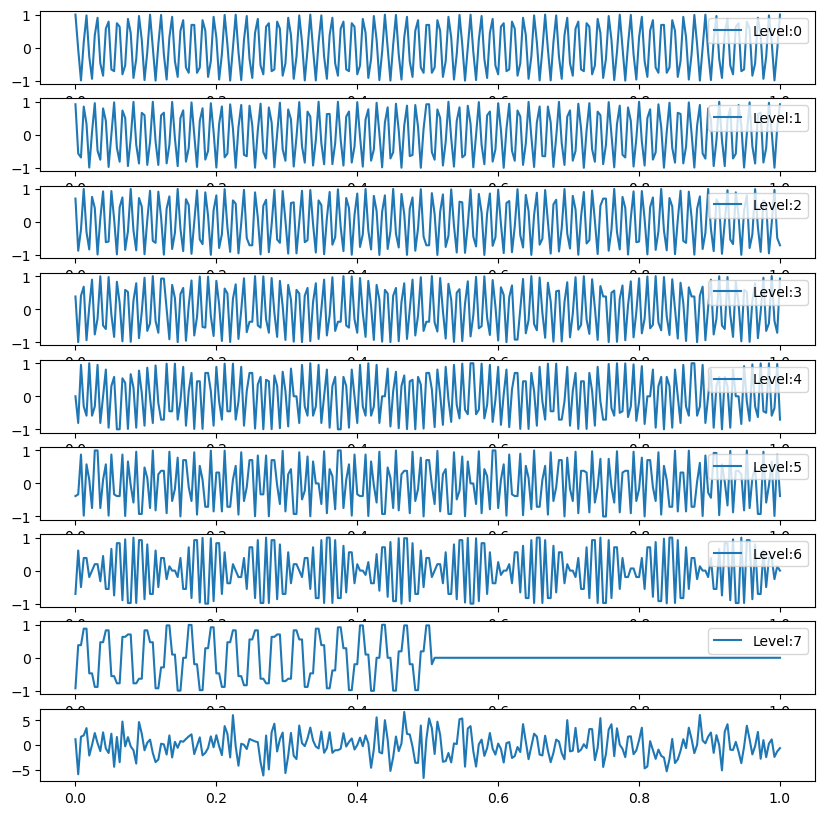

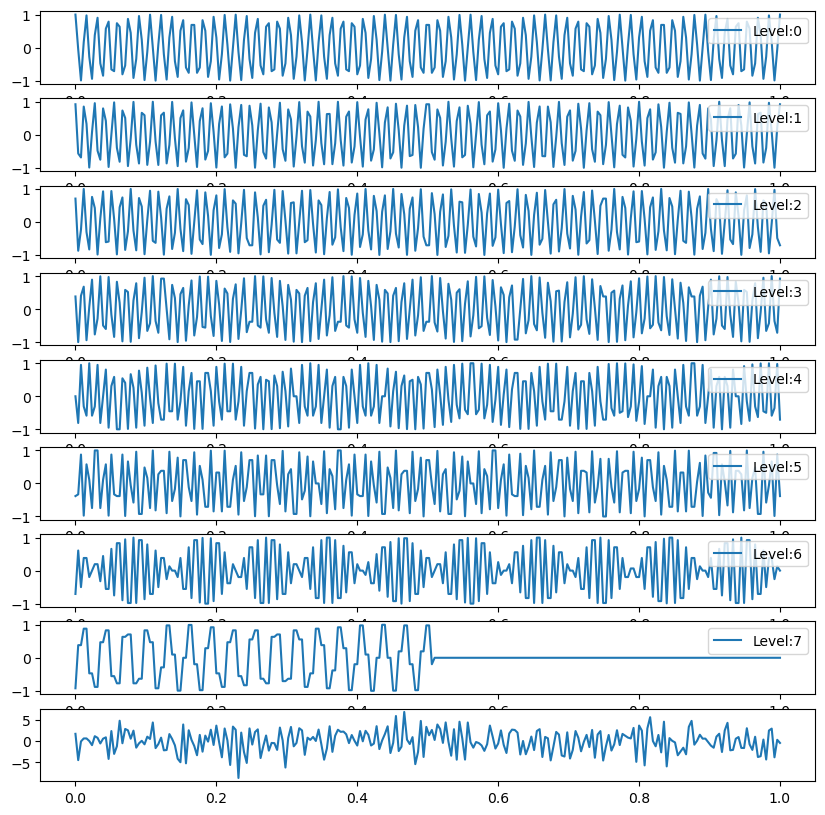

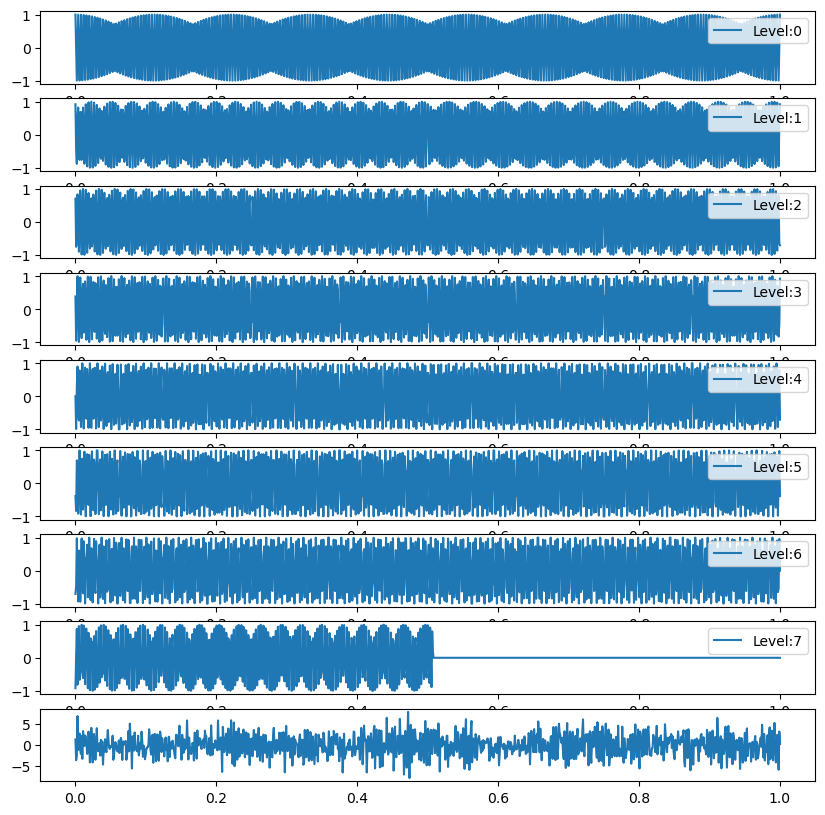

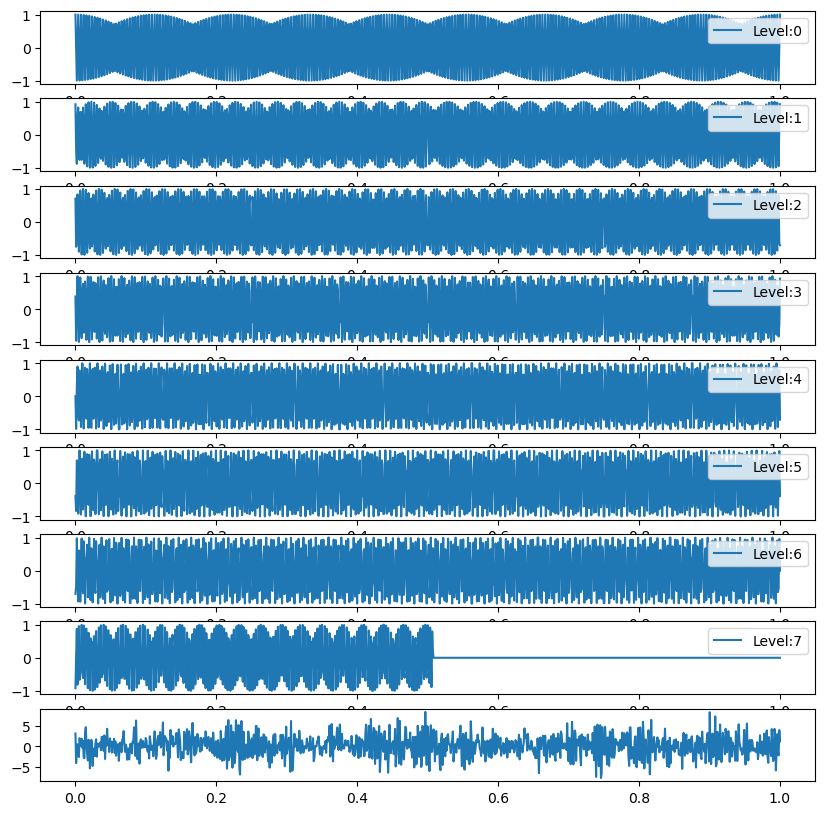

In [124]:
text_test_case = ["Hello,How Are You Doing?"]
binary_test_case = [ str(''.join(format(ord(i), '08b') for i in test_str)) for test_str in text_test_case]
def compare_string(target,test):
    #print("T:",test)
    #print("O:",target)
    N=0
    count=0
    for i in range(len(target)):
        if(target[i]=='2'):
            break
        count+=1 if target[i]==test[i] else 0
        N+=1
    #print(N)
    return count*100/N
def compare_remain(target,test):
    N=len(target)
    if(len(test)>len(target)):
        target=target+'2'*(len(test)-len(target))
    count=0
    
    for i in range(N,len(target),1):
        count+=1 if target[i]==test[i] else 0
    return count*100/N
generate_parameter = [[2],[1],[1],[0,4,16,64,256],[False],[0.125,1]]
for p in generate_parameter[0]:
    for j in generate_parameter[1]:
        for k in generate_parameter[2]:
            for l in generate_parameter[3]:
                for m in generate_parameter[4]:
                    for n in generate_parameter[5]:
                        for t in binary_test_case:
                            print(f"length:{len(t)},padding_freq:{p},duration_update:{j},duartion:{k},initfrewq:{l},dynamic_freq{m},step_feq:{n}")
                            used_filtered=False
                            segment_freq,comb_signal,input_seperate_signal,datas,sampling_freq,freq_padding,time_per_change,all_time \
                            =generator_signal(t,p,j,k,init_freq=l,dynamic_padding=m,_step_factor=n)
                            decode_binary=[]
                           
                            fft_coeff = fft_range(time_per_change,sampling_freq,comb_signal,segment_freq)
                            string_out = ''.join(decode_binary)
                            count=0
                            for i,st in enumerate(datas):
                                #print(count,count+len(st))
                                percent = compare_string(st,string_out[count:count+len(st)])
                                remain_percent = compare_remain(st,string_out[count:count+len(st)])
                                print(f"layer:{i} percent{percent},freq_range:{segment_freq[i]} remina_percent:{remain_percent},ratio:{round(fft_coeff[i],2)}")
                                count=count+len(st)

                            #print(string_out)
                            print("percent: ",compare_string(t,string_out))





In [133]:
from tabulate import tabulate

text_test_case = ["Hello,How Are You Doing?"]
binary_test_case = [''.join(format(ord(i), '08b') for i in test_str) for test_str in text_test_case]

def compare_string(target,test):
    #print("T:",test)
    #print("O:",target)
    N=0
    count=0
    for i in range(len(target)):
        if(target[i]=='2'):
            break
        count+=1 if target[i]==test[i] else 0
        N+=1
    #print(N)
    count=N-count
    return round(count*100/N,2)
def compare_remain(target,test):
    
    count=0
    N=0

    for i in range(len(target)):
        if(target[i]!='2'):continue
        count+=1 if target[i]==test[i] else 0
        N+=1
    if(N==0):return -1
    count = N - count
    return round(count*100/N,2)
decode_binary=[]
generate_parameter = [[1,1.5,2,4,8,16], [1], [1], [0], [True], [1],[0],[1024,2048,4096,8192,16384,32768,65536]]

results = []  # To store table data

for p in generate_parameter[0]:
    for j in generate_parameter[1]:
        for k in generate_parameter[2]:
            for l in generate_parameter[3]:
                for m in generate_parameter[4]:
                    for n in generate_parameter[5]:
                        for t in binary_test_case:
                            for s in generate_parameter[6]:
                                for ss in generate_parameter[7]:
                                    used_filtered = False
                                    segment_freq, comb_signal, input_seperate_signal, datas, sampling_freq, freq_padding, time_per_change, all_time \
                                        = generator_signal(t, p, j, k, init_freq=l, dynamic_padding=m, _step_factor=n,full_plot=False,snr_db=s,sampling_rate=ss)

                                    decode_binary = []
                            
                                    fft_coeff = fft_range(time_per_change, sampling_freq, comb_signal, segment_freq)
                                    string_out = ''.join(decode_binary)

                                    total_percent = compare_string(t, string_out)
                                    count=0
                                    print("all_percent",compare_string(t,string_out))

                                    for i, st in enumerate(datas):
                                        percent = compare_string(st,string_out[count:count+len(st)])
                                        remain_percent = compare_remain(st,string_out[count:count+len(st)])
                                        print(f"layer:{i} percent{percent},freq_range:{segment_freq[i]} remina_percent:{remain_percent},ratio:{round(fft_coeff[i],2)},snr{s} all_percent{compare_string(t,string_out)}",)
                                        count=count+len(st)
                                        results.append([
                                            len(t), p, j, k, l, m, n, i, segment_freq[i], percent,sampling_freq,remain_percent,fft_coeff[i],s,compare_string(t,string_out)
                                        ])
                                


# Print the table
headers = ["Binary Length", "Padding Freq", "Duration Update", "Duration", "Init Freq", "Dynamic Freq", "Step Freq", "Layer", "Freq Range", "Accuracy (%)","sampling_freq","remain_percent","ratio","SNR_db","allpercent"]
print(tabulate(results, headers=headers, tablefmt="grid"))


[1, 2]
[4, 6]
[10, 14]
[22, 30]
[46, 62]
[94, 126]
[190, 254]
[382, 510]
all_percent 55.21
layer:0 percent0.0,freq_range:[1 2] remina_percent:-1,ratio:1.59,snr0 all_percent55.21
layer:1 percent0.0,freq_range:[4 6] remina_percent:-1,ratio:3.02,snr0 all_percent55.21
layer:2 percent50.0,freq_range:[10 14] remina_percent:-1,ratio:8.12,snr0 all_percent55.21
layer:3 percent25.0,freq_range:[22 30] remina_percent:-1,ratio:4.26,snr0 all_percent55.21
layer:4 percent18.75,freq_range:[46 62] remina_percent:-1,ratio:2.74,snr0 all_percent55.21
layer:5 percent31.25,freq_range:[ 94 126] remina_percent:-1,ratio:1.83,snr0 all_percent55.21
layer:6 percent56.25,freq_range:[190 254] remina_percent:-1,ratio:2.03,snr0 all_percent55.21
layer:7 percent81.54,freq_range:[382 510] remina_percent:61.9,ratio:3.6,snr0 all_percent55.21
[1, 2]
[4, 6]
[10, 14]
[22, 30]
[46, 62]
[94, 126]
[190, 254]
[382, 510]
all_percent 36.98
layer:0 percent0.0,freq_range:[1 2] remina_percent:-1,ratio:1.75,snr0 all_percent36.98
layer:

In [131]:
import pandas as pd

# Define column headers
headers = ["Length", "Padding Freq", "Duration Update", "Duration", "Init Freq", "Dynamic Freq",\
            "Step Freq", "Layer", "Freq Range","Accuracy (%)","sampling_freq","remain_percent ","ratio","SNR_db","all percent"]

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=headers)

# Save to an Excel file
df.to_excel("results.xlsx", index=False)

print("Results saved to 'results.xlsx'")


Results saved to 'results.xlsx'
